# CalPred model

# Introduction
Polygenic scores (PGS) have emerged as the tool of choice for genomic prediction in personalized medicine. A critical barrier in PGS use is their **context-specific accuracy** – their accuracy varies across genetic ancestry, age, sex, socioeconomic status and other factors. Such context-specific accuracy suggests that two individuals can have the same point predictions with different precisions. We propose an approach (CalPred) to incorporate context-specificity into trait prediction intervals that are allowed to vary across contexts. As an example, consider the case of two individuals with the same PGS-based predictions for low-density lipoprotein cholesterol (LDL) of 120 mg/dL. If the two individuals have different contexts (e.g., sex) that are known to impact PGS accuracy (e.g., $R^2$=0.1 in men vs. 0.2 in women), their prediction intervals will also vary (e.g., 120 ± 40 mg/dL vs. 120 ± 10 mg/dL). In this example the second individual is more likely to meet a decision criterion of LDL>100 mg/dL for clinical intervention.

We model such prediction intervals using the following approaches by relating each individual's prediction variance to their contexts.
$$ 
y_i \sim \mathcal{N} (\mu(\mathbf{c}_i ),\sigma^2 (\mathbf{c}_i )),i=1,…,N
$$
where 
$$
\mu(\mathbf{c}_i)=\mathbf{c}_i^\top \boldsymbol{\beta}_\mu, \sigma^2 (\mathbf{c}_i )=\exp⁡(\mathbf{c}_i^\top\boldsymbol{\beta}_\sigma).
$$

# Simulate phenotype with context-specific accuracy
We simulate variable prediction accuracy across genetic ancestry continuum, age and sex. For simplicity, we assume that the point predictions are given, denoted as $\hat{y} \sim \mathcal{N}(0, 1)$, and we simulate phenotypes $y$ with:

$$
y \sim \mathcal{N}\left(
\hat{y}, 
\exp(\beta_{\sigma,0} + 
\beta_{\sigma, \text{ancestry}} \times \text{ancestry} +
\beta_{\sigma, \text{age}} \times \text{age} +
\beta_{\sigma, \text{sex}} \times \text{sex}
) 
\right)
$$
First, we set $\beta_{\sigma,0} = \log (0.7 / 0.3)$ such that the baseline $R^2 = 0.3$ to control the baseline accuracy. Then we set $\beta_{\sigma, \text{ancestry}} = 0.15, \beta_{\sigma, \text{age}} = 0.25, \beta_{\sigma, \text{sex}} = 0.2$ (these effects are standardized with regard to each standard deviation of context.

In [1]:
source("calpred.R")
library(ggplot2); theme_set(theme_bw())
library(dplyr)
library(patchwork)

options(repr.plot.res = 200)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
n_indiv <- 20000

set.seed(1234)

# simulate contexts
data <- data.frame(
    yhat = rnorm(n_indiv),
    intercept = 1,
    ancestry = runif(n_indiv),
    age = rnorm(n_indiv, 40, 10),
    sex = rbinom(n_indiv, size=1, prob = 0.5)
)
data <- data %>% mutate(
    ancestry_label = cut_number(ancestry, 5, labels=FALSE),
    age_label = cut_number(age, 5, labels=FALSE),
    sex_label = ifelse(sex > 0, "Female", "Male")
)

data[, c('ancestry', 'age', 'sex')] <- scale(data[, c('ancestry', 'age', 'sex')])

# simulate phenotype
y_mean <- data[, 'yhat']
sd_mat <- as.matrix(data[, c("intercept", "ancestry", "age", "sex")])

# specify coefficients
sd_coef <- c(
    intercept = log(7/3),
    ancestry = 0.2,
    age = -0.15,
    sex = 0.2
)
y_sd <- sqrt(exp(sd_mat %*% sd_coef))
y <- rnorm(n = n_indiv, mean = y_mean, sd = y_sd)
data[, 'y'] <- y

# Visualizing context-specific accuracy

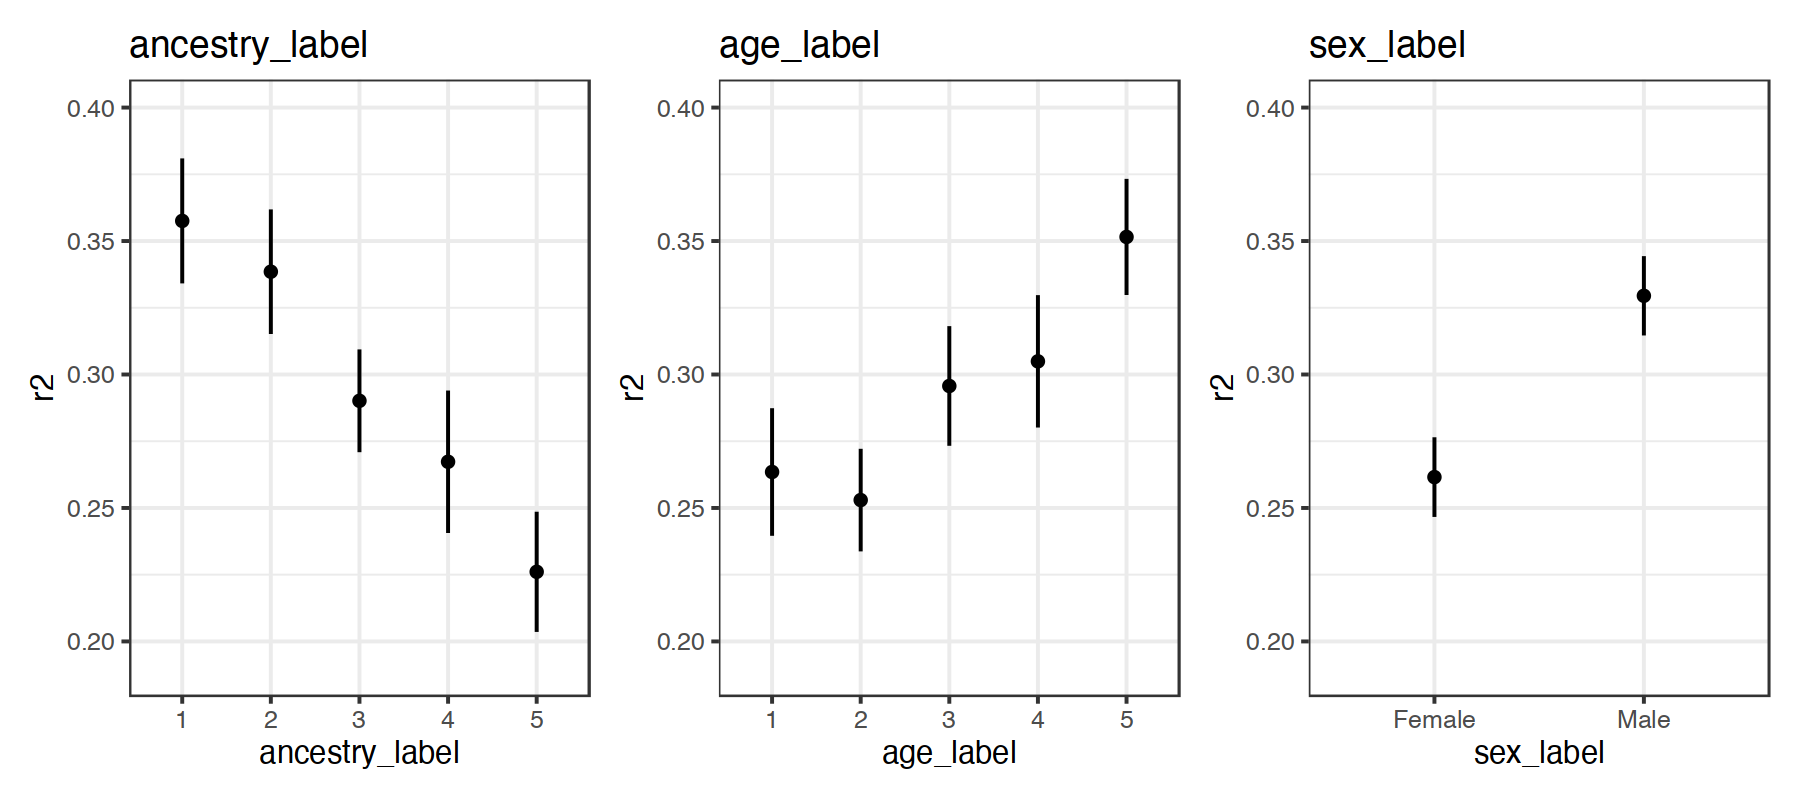

In [3]:
plot_list <- list()

for (context in c("ancestry_label", "age_label", "sex_label")) {
    
    stats <- compute_stats(y=data[, 'y'], pred=data[, 'yhat'], group=data[, context])
    p <- plot_stats(stats$bootstrap_stats, 'r2') + 
          labs(title = context, x=context) +
          ylim(0.19, 0.4)
    plot_list[[context]] <- p
}

options(repr.plot.width = 9, repr.plot.height = 4)
wrap_plots(plotlist = plot_list, ncol = 3)

# Fit CalPred model

In [4]:
mean_mat <- as.matrix(data[, c("intercept", "yhat")])
sd_mat <- as.matrix(data[, c("intercept", "ancestry", "age", "sex")])

fit <- train(mean_mat=mean_mat, sd_mat=sd_mat, y=y)
pred <- predict(mean_mat=mean_mat, sd_mat=sd_mat, mean_coef=fit$mean_coef, sd_coef=fit$sd_coef)

# Quality of parameter fit
We first check the quality of parameter fit and observe a high consistency between fitted coefficients `fit$sd_coef` and true coefficients `sd_coef`  

# Check for calibration

In [5]:
mean_mat <- as.matrix(data[, c("intercept", "yhat")])
sd_mat <- as.matrix(data[, c("intercept"), drop=FALSE])

fit <- train(mean_mat=mean_mat, sd_mat=sd_mat, y=y)
generic_pred <- predict(mean_mat=mean_mat, sd_mat=sd_mat, mean_coef=fit$mean_coef, sd_coef=fit$sd_coef)

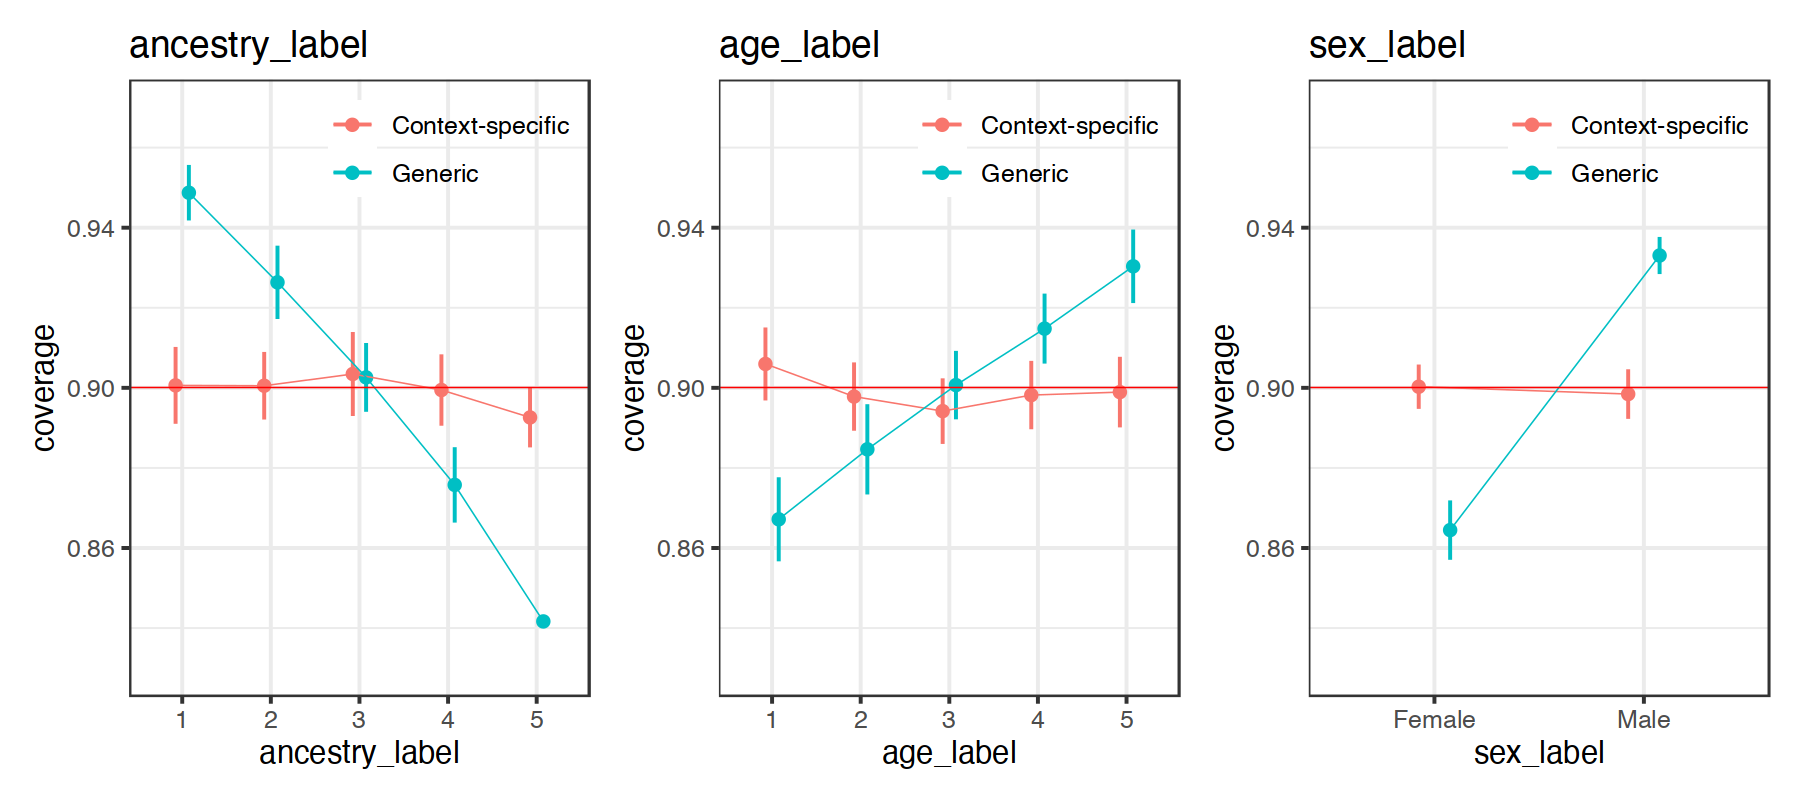

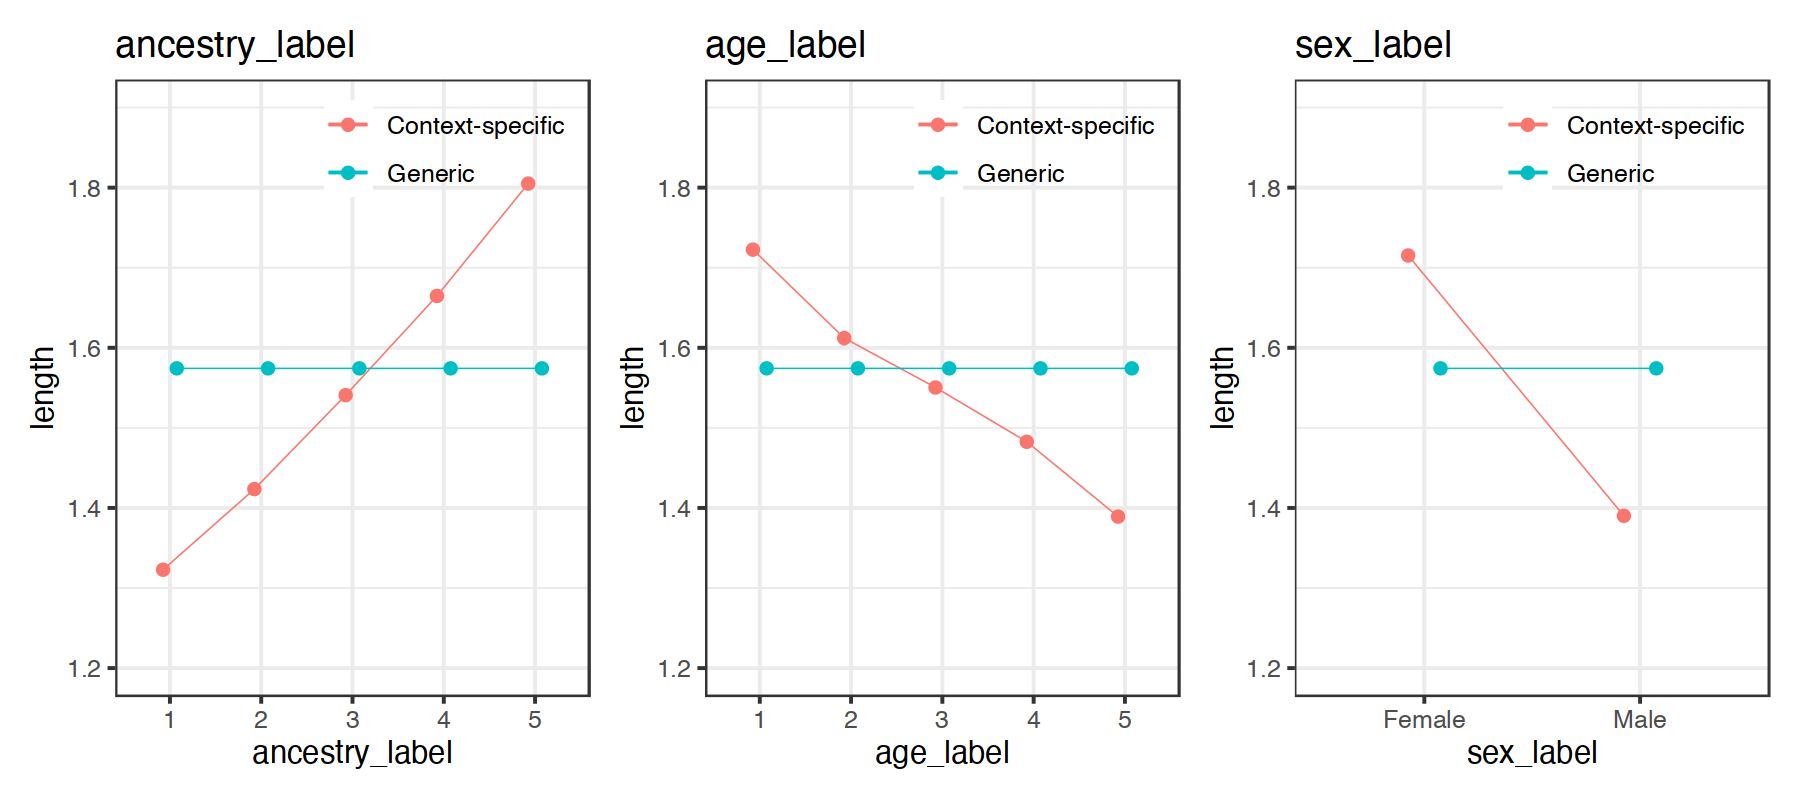

In [6]:
coverage_plots <- list()
length_plots <- list()
for (context in c("ancestry_label", "age_label", "sex_label")) {
        
    stats <- compute_stats(y=data[, 'y'], pred=data[, 'yhat'], predsd=pred$sd, group=data[, context])
    generic_stats <- compute_stats(y=data[, 'y'], pred=data[, 'yhat'], predsd=generic_pred$sd, group=data[, context])
    stats_list <- list(`Generic`=generic_stats$bootstrap_stats, `Context-specific`=stats$bootstrap_stats)
    
    coverage_plots[[context]] <- plot_stats(stats_list, 'coverage') + 
          labs(title = context, x=context) +
          ylim(0.83, 0.97) + geom_hline(yintercept=0.9, color = "red", linewidth=0.2)
    
    length_plots[[context]] <- plot_stats(stats_list, 'length') + 
          labs(title = context, x=context) + ylim(1.2, 1.9)
    
}
options(repr.plot.width = 9, repr.plot.height = 4)
wrap_plots(coverage_plots, ncol = 3)
wrap_plots(length_plots, ncol = 3)

# Example analysis for individual-level trait
Next we present an example workflow for analyzing trait.

In [7]:
pheno <- sort(rnbinom(n_indiv, mu=120, size = 10))
data[, 'pheno'] <- pheno[rank(data[, 'y'], ties.method='first')]

In [8]:
# 1. divide into train and test
# 2. map pheno to pheno_q
# 3. map back
# 4. show calibration results
# 5. illustrate groups of individuals and characterize their contexts

Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


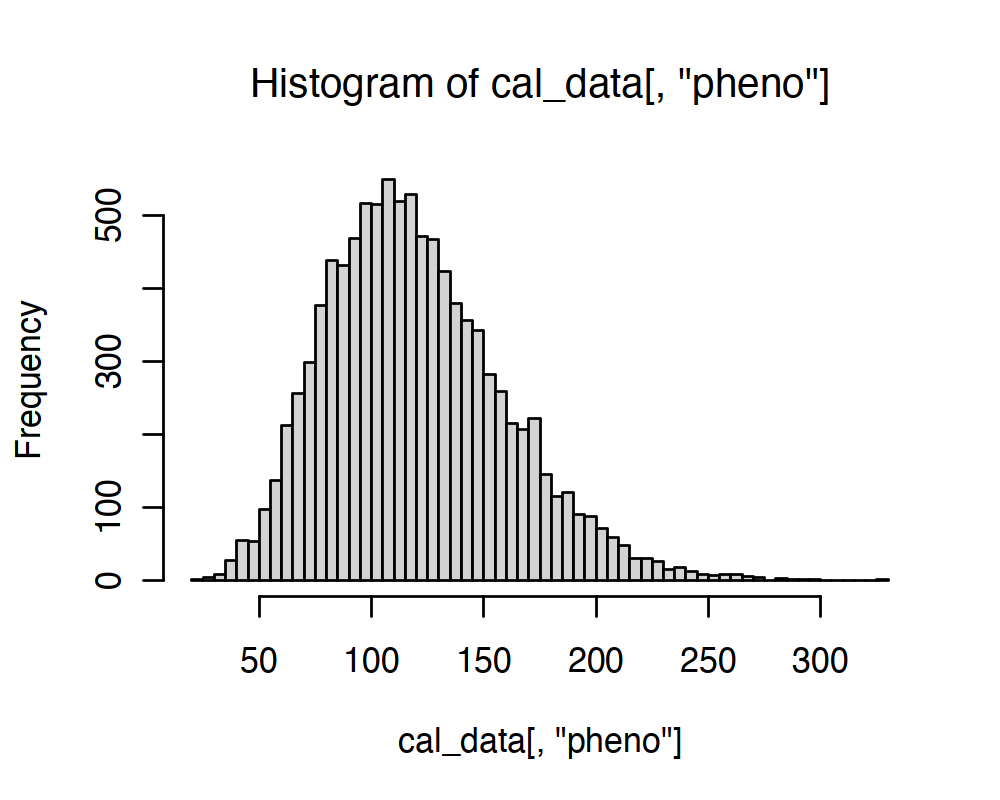

In [9]:
cal_data <- data[1:10000, ]
test_data <- data[10001:n_indiv, ]

qtbl <- normalize_table(cal_data[, 'pheno']) # map quantile to phenotype
cal_data['pheno_q'] <- qtbl['q']
f <- approxfun(qtbl$x, qtbl$q, rule=2)
inverse_f <- approxfun(qtbl$q, qtbl$x, rule=2)
test_data['pheno_q'] <- f(test_data[, 'pheno'])

options(repr.plot.width = 5, repr.plot.height = 4)
hist(cal_data[, 'pheno'], breaks=50)

In [10]:
# use calibration data to train the model
mean_mat <- as.matrix(cal_data[, c("intercept", "yhat")])
sd_mat <- as.matrix(cal_data[, c("intercept", "ancestry", "age", "sex")])
y <- cal_data[, 'pheno_q']
fit <- train(
    mean_mat=mean_mat, 
    sd_mat=sd_mat, 
    y=y
)

# use calibration data to train the model
mean_mat <- as.matrix(test_data[, c("intercept", "yhat")])
sd_mat <- as.matrix(test_data[, c("intercept", "ancestry", "age", "sex")])
pred <- predict(mean_mat=mean_mat, sd_mat=sd_mat, mean_coef=fit$mean_coef, sd_coef=fit$sd_coef)
pred <- pred %>%
    rowwise() %>%
    mutate(low = inverse_f(mean - sd * 1.645), high = inverse_f(mean + sd * 1.645))

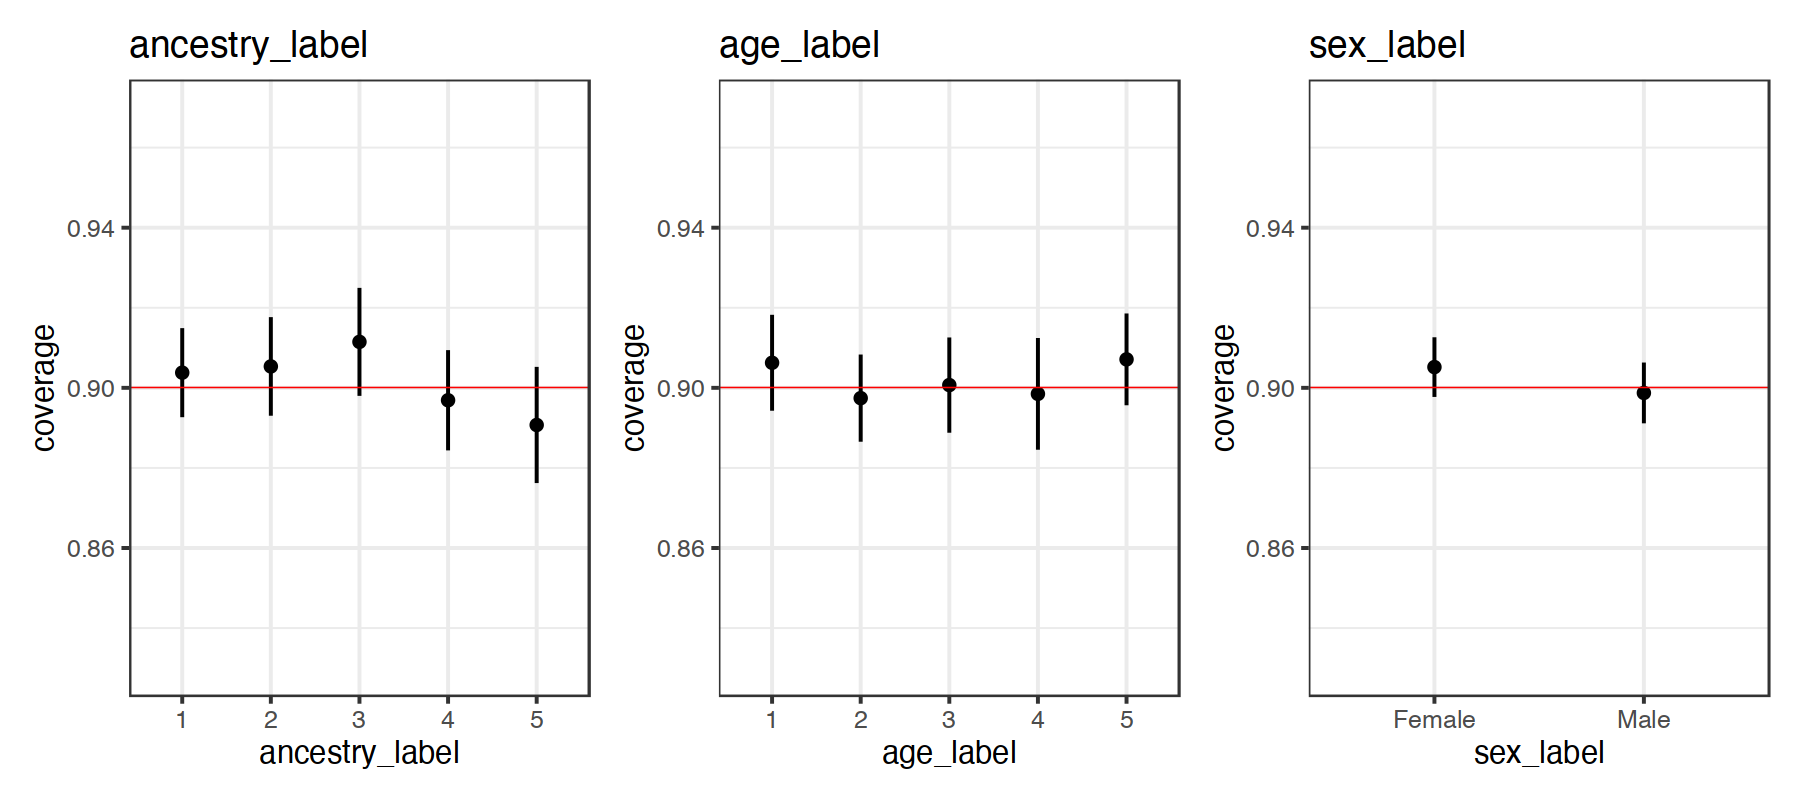

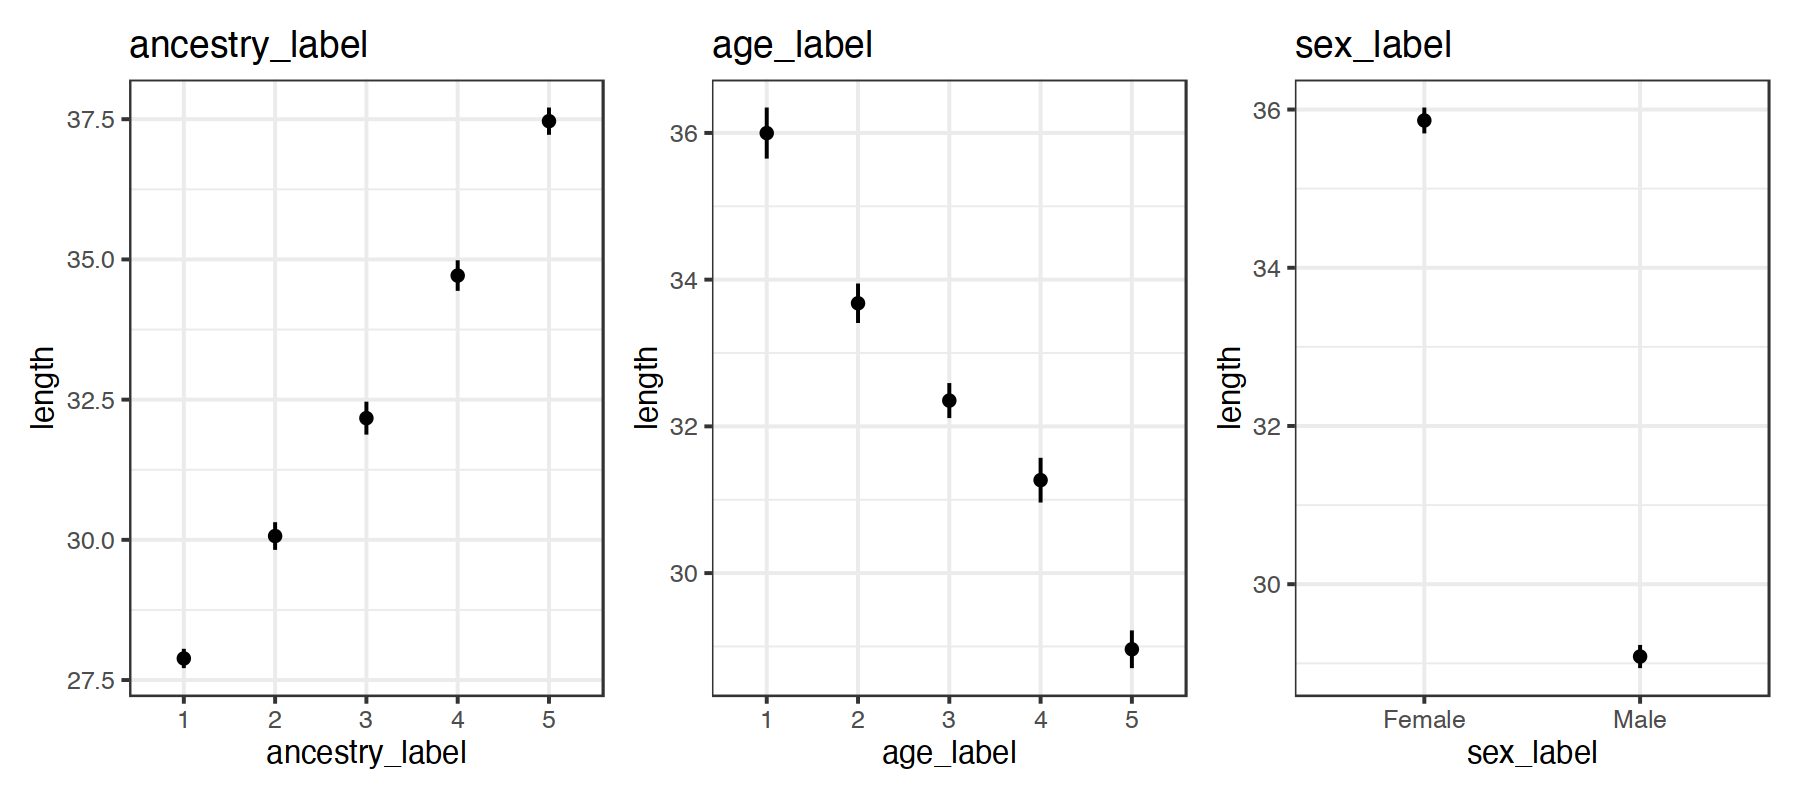

In [11]:
coverage_plots <- list()
length_plots <- list()
for (context in c("ancestry_label", "age_label", "sex_label")) {
        
    stats <- compute_stats(
        y=test_data[, 'pheno'], 
        pred=pred$mean, 
        predlow=pred$low, 
        predhigh=pred$high, 
        group=test_data[, context]
    )
    
    coverage_plots[[context]] <- plot_stats(stats$bootstrap_stats, 'coverage') + 
          labs(title = context, x=context) +
          ylim(0.83, 0.97) + geom_hline(yintercept=0.9, color = "red", linewidth=0.2)
    
    length_plots[[context]] <- plot_stats(stats$bootstrap_stats, 'length') + 
          labs(title = context, x=context)

}

options(repr.plot.width = 9, repr.plot.height = 4)
wrap_plots(coverage_plots, ncol = 3)
wrap_plots(length_plots, ncol = 3)